## Dependencies

In [1]:
!pip install --quiet efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings, time
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import optimizers, Sequential, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import efficientnet.tfkeras as efn
from cassava_scripts import *
from scripts_step_lr_schedulers import *
import tensorflow_addons as tfa


seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

### Hardware configuration

In [3]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
strategy, tpu = set_up_strategy()

AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')


# Mixed precision
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_bfloat16')
mixed_precision.set_policy(policy)

# XLA
tf.config.optimizer.set_jit(True)

Running on TPU grpc://10.0.0.2:8470
REPLICAS: 8


# Model parameters

In [4]:
BATCH_SIZE = 8 * REPLICAS
BATCH_SIZE_CL = 8 * REPLICAS
LEARNING_RATE = 1e-5 * REPLICAS
EPOCHS_CL = 10
EPOCHS = 15
HEIGHT = 512
WIDTH = 512
HEIGHT_DT = 512
WIDTH_DT = 512
CHANNELS = 3
N_CLASSES = 5
N_FOLDS = 5
FOLDS_USED = 1
ES_PATIENCE = 5

# Load data

In [5]:
database_base_path = '/kaggle/input/cassava-leaf-disease-classification/'
train = pd.read_csv(f'{database_base_path}train.csv')
print(f'Train samples: {len(train)}')

GCS_PATH = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-center-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord)
# GCS_PATH_EXT = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-external-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord) (External)
# GCS_PATH_CLASSES = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-classes-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord) by classes
# GCS_PATH_EXT_CLASSES = KaggleDatasets().get_gcs_path(f'cassava-leaf-disease-tfrecords-classes-ext-{HEIGHT_DT}x{WIDTH_DT}') # Center croped and resized (50 TFRecord) (External) by classes


FILENAMES_COMP = tf.io.gfile.glob(GCS_PATH + '/*.tfrec')
# FILENAMES_2019 = tf.io.gfile.glob(GCS_PATH_EXT + '/*.tfrec')

# FILENAMES_COMP_CBB = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBB*.tfrec')
# FILENAMES_COMP_CBSD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CBSD*.tfrec')
# FILENAMES_COMP_CGM = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CGM*.tfrec')
# FILENAMES_COMP_CMD = tf.io.gfile.glob(GCS_PATH_CLASSES + '/CMD*.tfrec')
# FILENAMES_COMP_Healthy = tf.io.gfile.glob(GCS_PATH_CLASSES + '/Healthy*.tfrec')

# FILENAMES_2019_CBB = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBB*.tfrec')
# FILENAMES_2019_CBSD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CBSD*.tfrec')
# FILENAMES_2019_CGM = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CGM*.tfrec')
# FILENAMES_2019_CMD = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/CMD*.tfrec')
# FILENAMES_2019_Healthy = tf.io.gfile.glob(GCS_PATH_EXT_CLASSES + '/Healthy*.tfrec')

TRAINING_FILENAMES = FILENAMES_COMP
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)

print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
display(train.head())

Train samples: 21397
GCS: train images: 21395


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


# Augmentation

In [6]:
def data_augment(image, label):
#     p_rotation = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     p_shear = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
#     # Shear
#     if p_shear > .2:
#         if p_shear > .6:
#             image = transform_shear(image, HEIGHT, shear=20.)
#         else:
#             image = transform_shear(image, HEIGHT, shear=-20.)
            
#     # Rotation
#     if p_rotation > .2:
#         if p_rotation > .6:
#             image = transform_rotation(image, HEIGHT, rotation=45.)
#         else:
#             image = transform_rotation(image, HEIGHT, rotation=-45.)
            
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    # Crops
    if p_crop > .6:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.5)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.6)
        elif p_crop > .7:
            image = tf.image.central_crop(image, central_fraction=.7)
        else:
            image = tf.image.central_crop(image, central_fraction=.8)
    elif p_crop > .3:
        crop_size = tf.random.uniform([], int(HEIGHT*.6), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])

    if p_cutout > .5:
        image = data_augment_cutout(image)
        
    return image, label

## Auxiliary functions

In [7]:
# CutOut
def data_augment_cutout(image, min_mask_size=(int(HEIGHT * .1), int(HEIGHT * .1)), 
                        max_mask_size=(int(HEIGHT * .125), int(HEIGHT * .125))):
    p_cutout = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    if p_cutout > .85: # 10~15 cut outs
        n_cutout = tf.random.uniform([], 10, 15, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .6: # 5~10 cut outs
        n_cutout = tf.random.uniform([], 5, 10, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    elif p_cutout > .25: # 2~5 cut outs
        n_cutout = tf.random.uniform([], 2, 5, dtype=tf.int32)
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=n_cutout)
    else: # 1 cut out
        image = random_cutout(image, HEIGHT, WIDTH, 
                              min_mask_size=min_mask_size, max_mask_size=max_mask_size, k=1)

    return image

In [8]:
# Datasets utility functions
def random_crop(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.random_crop(image, size=[HEIGHT, WIDTH, CHANNELS])
    return image, label

def prepare_image(image, label):
    """
        Resize and reshape images to the expected size.
    """
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image, label

def center_crop_(image, label, height_rs, width_rs, height=HEIGHT_DT, width=WIDTH_DT, channels=3):
    image = tf.reshape(image, [height, width, channels]) # Original shape
    
    h, w = image.shape[0], image.shape[1]
    if h > w:
        image = tf.image.crop_to_bounding_box(image, (h - w) // 2, 0, w, w)
    else:
        image = tf.image.crop_to_bounding_box(image, 0, (w - h) // 2, h, h)
        
    image = tf.image.resize(image, [height_rs, width_rs]) # Expected shape
    return image, label


def read_tfrecord_(example, labeled=True, sparse=True, n_classes=5):
    """
        1. Parse data based on the 'TFREC_FORMAT' map.
        2. Decode image.
        3. If 'labeled' returns (image, label) if not (image, name).
    """
    if labeled:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'target': tf.io.FixedLenFeature([], tf.int64), 
        }
    else:
        TFREC_FORMAT = {
            'image': tf.io.FixedLenFeature([], tf.string), 
            'image_name': tf.io.FixedLenFeature([], tf.string), 
        }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    if labeled:
        label_or_name = tf.cast(example['target'], tf.int32)
        if not sparse: # One-Hot Encoding needed to use "categorical_crossentropy" loss
            label_or_name = tf.one_hot(tf.cast(label_or_name, tf.int32), n_classes)
    else:
        label_or_name = example['image_name']
    return image, label_or_name

def get_dataset(filenames, labeled=True, ordered=False, repeated=False, 
                cached=False, augment=False, batch_size=BATCH_SIZE, sparse=True):
    """
        Return a Tensorflow dataset ready for training or inference.
    """
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
        dataset = tf.data.Dataset.list_files(filenames)
        dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTO)
    else:
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(lambda x: read_tfrecord_(x, labeled=labeled, sparse=sparse), num_parallel_calls=AUTO)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
        
    dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_image, num_parallel_calls=AUTO)
    
    if labeled:
        dataset = dataset.map(lambda x, y: conf_output(x, y, sparse=sparse), num_parallel_calls=AUTO)
    
    if not ordered:
        dataset = dataset.shuffle(2048)
    if repeated:
        dataset = dataset.repeat()
        
    dataset = dataset.batch(batch_size)
    
    if cached:
        dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def conf_output(image, label, sparse=False):
    """
        Configure the output of the dataset.
    """
    aux_label = [0.]
    aux_2_label = [0.]
    
    if sparse:
        if label == 4: # Healthy
            aux_label = [1.]
        if label == 3: # CMD
            aux_2_label = [1.]
    else:
        if tf.math.argmax(label, axis=-1) == 4: # Healthy
            aux_label = [1.]
        if tf.math.argmax(label, axis=-1) == 3: # CMD
            aux_2_label = [1.]
        
    return (image, (label, aux_label, aux_2_label))

# Training data samples (with augmentation)

In [9]:
# train_dataset = get_dataset(FILENAMES_COMP, ordered=True, augment=True)
# train_iter = iter(train_dataset.unbatch().batch(20))

# display_batch_of_images(next(train_iter))
# display_batch_of_images(next(train_iter))

# Model

In [10]:
def encoder_fn(input_shape):
    inputs = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB3(input_tensor=inputs, 
                                    include_top=False, 
                                    weights='noisy-student', 
                                    pooling='avg')
    
    model = Model(inputs=inputs, outputs=base_model.output)
    return model

def add_projection_head(input_shape, encoder, num_projection_layers=1):
    inputs = L.Input(shape=input_shape, name='input_image')
    features = encoder(inputs)

    outputs = L.Dense(256, activation='relu', name='projection_head')(features)
    
    for n in range(num_projection_layers):
        x = L.ReLU()(outputs)
        x = L.Dense(256, name=f'projection_head_{n}')(x)
        x = L.Dropout(.1)(x)
        x = L.Add()([outputs, x])
        outputs = L.LayerNormalization(dtype='float32')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

def classifier_fn(input_shape, N_CLASSES, encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable
        
    unfreeze_model(encoder) # unfreeze all layers except "batch normalization"
    inputs = L.Input(shape=input_shape, name='input_image')
    
    features = encoder(inputs)
    features = L.Dropout(.5)(features)
    features = L.Dense(512, activation='relu')(features)
    features = L.Dropout(.5)(features)
    
    output = L.Dense(N_CLASSES, activation='softmax', name='output', dtype='float32')(features)
    output_healthy = L.Dense(1, activation='sigmoid', name='output_healthy', dtype='float32')(features)
    output_cmd = L.Dense(1, activation='sigmoid', name='output_cmd', dtype='float32')(features)
    
    model = Model(inputs=inputs, outputs=[output, output_healthy, output_cmd])
    return model

In [11]:
temperature = 0.1

class SupervisedContrastiveLoss(losses.Loss):
    def __init__(self, temperature=0.1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

### Learning rate schedule

5010 total steps and 334 steps per epoch
Learning rate schedule: 1e-08 to 8e-05 to 1e-06


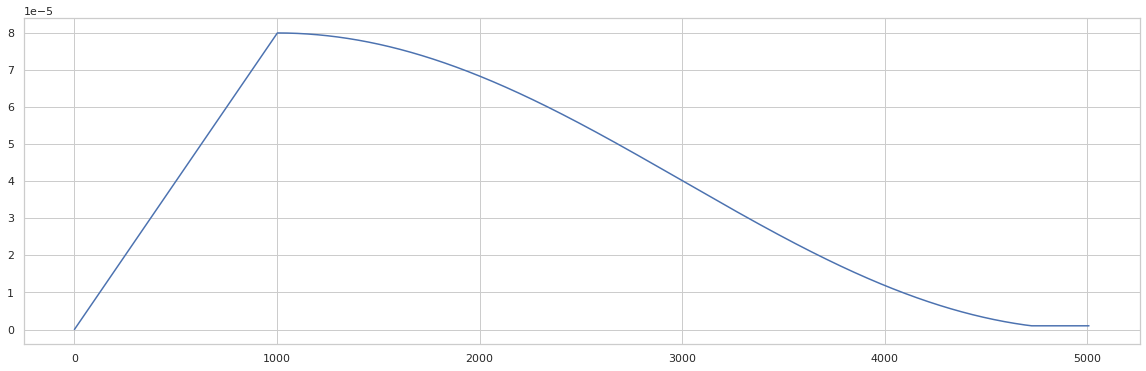

In [12]:
lr_start = 1e-8
lr_min = 1e-6
lr_max = LEARNING_RATE
num_cycles = 1
warmup_epochs = 3
hold_max_epochs = 0
total_epochs = EPOCHS
step_size = (NUM_TRAINING_IMAGES//BATCH_SIZE)
hold_max_steps = hold_max_epochs * step_size
total_steps = total_epochs * step_size
warmup_steps = warmup_epochs * step_size


def lrfn(total_steps, warmup_steps=0, lr_start=1e-4, lr_max=1e-3, lr_min=1e-4, num_cycles=1.):
    @tf.function
    def cosine_with_hard_restarts_schedule_with_warmup_(step):
        """ Create a schedule with a learning rate that decreases following the
        values of the cosine function with several hard restarts, after a warmup
        period during which it increases linearly between 0 and 1.
        """

        if step < warmup_steps:
            lr = (lr_max - lr_start) / warmup_steps * step + lr_start
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            lr = lr_max * (0.5 * (1.0 + tf.math.cos(np.pi * ((num_cycles * progress) % 1.0))))
            if lr_min is not None:
                lr = tf.math.maximum(lr_min, float(lr))
        return lr
    return cosine_with_hard_restarts_schedule_with_warmup_

lrfn_fn = lrfn(total_steps, warmup_steps, lr_start, lr_max, lr_min, num_cycles)
rng = [i for i in range(total_steps)]
y = [lrfn_fn(tf.cast(x, tf.float32)) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{total_steps} total steps and {step_size} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

Classifier Learning rate scheduler
3340 total steps and 334 steps per epoch
Learning rate schedule: 1e-08 to 8e-05 to 1e-06


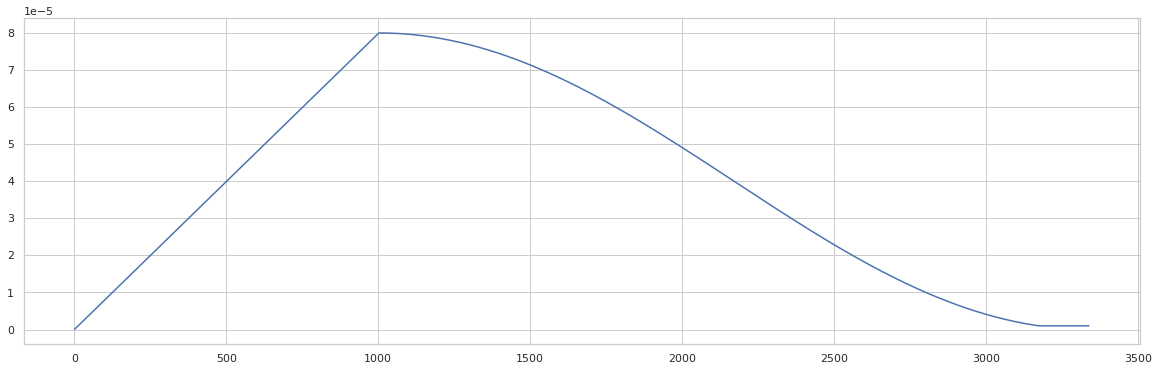

In [13]:
print('Classifier Learning rate scheduler')
step_size_cl = (NUM_TRAINING_IMAGES//BATCH_SIZE_CL)
total_steps_cl = (EPOCHS_CL * step_size_cl)
warmup_steps_cl = warmup_epochs * step_size_cl #1
num_cycles_cl = 1



lrfn_fn = lrfn(total_steps_cl, warmup_steps_cl, lr_start, lr_max, lr_min, num_cycles_cl)
rng = [i for i in range(total_steps_cl)]
y = [lrfn_fn(tf.cast(x, tf.float32)) for x in rng]

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

print(f'{total_steps_cl} total steps and {step_size_cl} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

# Training

In [14]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
oof_pred = []; oof_labels = []; oof_names = []; oof_folds = []; history_list = []; oof_embed = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    if fold >= FOLDS_USED:
        break
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    K.clear_session()
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')

    # Create train and validation sets
    TRAIN_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_CBB = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBB%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_CBSD = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CBSD%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_CGM = tf.io.gfile.glob([GCS_PATH_CLASSES + '/CGM%.2i*.tfrec' % x for x in idxT])
#     FILENAMES_COMP_Healthy = tf.io.gfile.glob([GCS_PATH_CLASSES + '/Healthy%.2i*.tfrec' % x for x in idxT])
    
    VALID_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/Id_train%.2i*.tfrec' % x for x in idxV])
    np.random.shuffle(TRAIN_FILENAMES)
    
    ct_train = count_data_items(TRAIN_FILENAMES)
    ct_valid = count_data_items(VALID_FILENAMES)
    
    step_size = (ct_train // BATCH_SIZE)
    warmup_steps = (warmup_epochs * step_size)
    total_steps = (total_epochs * step_size)
    
    ### Pre-train the encoder
    print('Pre-training the encoder using "Supervised Contrastive" Loss')
    with strategy.scope():
        encoder = encoder_fn((None, None, CHANNELS))
        unfreeze_model(encoder) # unfreeze all layers except "batch normalization"
        encoder_proj = add_projection_head((None, None, CHANNELS), encoder)
        encoder_proj.summary()

        lrfn_fn = lrfn(total_steps, warmup_steps, lr_start, lr_max, lr_min, num_cycles)
        optimizer = optimizers.Adam(learning_rate=lambda: lrfn_fn(tf.cast(optimizer.iterations, tf.float32)))
        encoder_proj.compile(optimizer=optimizer, 
                             loss=SupervisedContrastiveLoss(temperature))
        
    history_enc = encoder_proj.fit(x=get_dataset(TRAIN_FILENAMES, repeated=True, augment=True), 
#                                    validation_data=get_dataset(VALID_FILENAMES, ordered=True), 
                                   steps_per_epoch=step_size, 
                                   batch_size=BATCH_SIZE, 
                                   epochs=EPOCHS,
                                   verbose=2).history

    
    ### Train the classifier with the frozen encoder
    print('Training the classifier with the frozen encoder')
    step_size_cl = (ct_train // BATCH_SIZE_CL)
    total_steps_cl = (EPOCHS_CL * step_size_cl)
    
    with strategy.scope():
#         model = classifier_fn((None, None, CHANNELS), N_CLASSES, encoder, trainable=False)
        model = classifier_fn((None, None, CHANNELS), N_CLASSES, encoder, trainable=True)
        model.summary()

        lrfn_fn = lrfn(total_steps_cl, warmup_steps_cl, lr_start, lr_max, lr_min, num_cycles_cl)
#         optimizer = optimizers.Adam(learning_rate=lambda: lrfn_fn(tf.cast(optimizer.iterations, tf.float32)))
        optimizer = optimizers.SGD(learning_rate=lambda: lrfn_fn(tf.cast(optimizer.iterations, tf.float32)), 
                                   momentum=0.95, nesterov=True)
        model.compile(optimizer=optimizer, 
                      loss={'output': losses.CategoricalCrossentropy(label_smoothing=.3), 
                            'output_healthy': losses.BinaryCrossentropy(label_smoothing=.1), 
                            'output_cmd': losses.BinaryCrossentropy(label_smoothing=.1)},                      
                      loss_weights={'output': 1., 
                                    'output_healthy': .1, 
                                    'output_cmd': .1}, 
                      metrics={'output': metrics.CategoricalAccuracy(), 
                               'output_healthy': metrics.BinaryAccuracy(), 
                               'output_cmd': metrics.BinaryAccuracy()})
    
    model_path = f'model_{fold}.h5'
    ckpoint = ModelCheckpoint(model_path, mode='max', verbose=0, 
                              save_best_only=True, save_weights_only=True, 
                              monitor='val_output_categorical_accuracy')
    history = model.fit(x=get_dataset(TRAIN_FILENAMES, repeated=True, augment=True, batch_size=BATCH_SIZE_CL, sparse=False), 
                        validation_data=get_dataset(VALID_FILENAMES, ordered=True, batch_size=BATCH_SIZE_CL, sparse=False), 
                        steps_per_epoch=step_size, 
                        epochs=EPOCHS_CL, 
                        callbacks=[ckpoint], 
                        verbose=2).history
    
    
    ### RESULTS
    print(f"#### FOLD {fold+1} OOF Accuracy = {np.max(history['val_output_categorical_accuracy']):.3f}")
    
    history_list.append(history)
    # Load best model weights
    model.load_weights(model_path)

    # OOF predictions
    ds_valid = get_dataset(VALID_FILENAMES, ordered=True)
    oof_folds.append(np.full((ct_valid), fold, dtype='int8'))
    oof_labels.append([target[0].numpy() for img, target in iter(ds_valid.unbatch())])
    x_oof = ds_valid.map(lambda image, target: image)
    oof_pred.append(model.predict(x_oof)[0])
    # OOF names
    ds_valid_names = get_dataset(VALID_FILENAMES, labeled=False, ordered=True)
    oof_names.append(np.array([img_name.numpy().decode('utf-8') for img, img_name in iter(ds_valid_names.unbatch())]))
    oof_embed.append(encoder.predict(x_oof)) # OOF embeddings


FOLD: 1
TRAIN: [ 0  2  3  4  5  7  9 10 11 12 13 14] VALID: [1 6 8]
Pre-training the encoder using "Supervised Contrastive" Loss
43933696/43933088 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, None, None,  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 1536)         10783528    input_image[0][0]                
__________________________________________________________________________________________________
projection_head (Dense)         (None, 256)          393472      model[0][0]                      
_______________________________________________________________________________________________

## Model loss graph


FOLD: 1


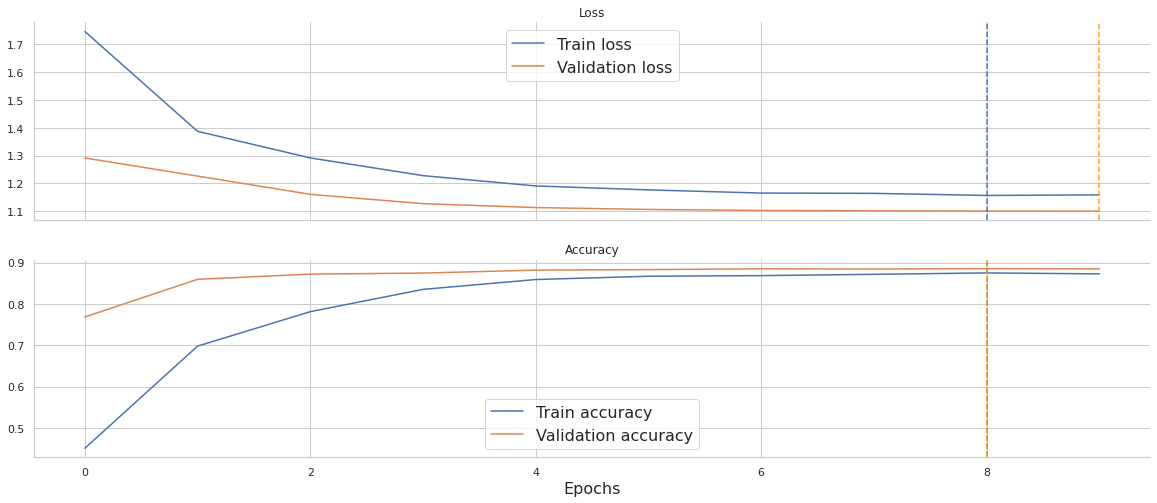

In [15]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_metrics(history, acc_name='output_categorical_accuracy')

# Model evaluation

In [16]:
y_true = np.concatenate(oof_labels)
# y_true = np.argmax(y_true, axis=-1)
y_prob = np.concatenate(oof_pred)
y_pred = np.argmax(y_prob, axis=-1)
folds = np.concatenate(oof_folds)
names = np.concatenate(oof_names)

acc = accuracy_score(y_true, y_pred)
print(f'Overall OOF Accuracy = {acc:.3f}')

df_oof = pd.DataFrame({'image_id':names, 'fold':fold, 
                       'target':y_true, 'pred':y_pred})

df_oof = df_oof.assign(probs=[prob for prob in y_prob])
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())

print(classification_report(y_true, y_pred, target_names=CLASSES))

Overall OOF Accuracy = 0.886


,image_id,fold,target,pred,probs
0,1000201771.jpg,0,3,3,"[0.057423968, 0.0593382, 0.06678373, 0.7598109..."
1,1000837476.jpg,0,3,3,"[0.051084016, 0.044562597, 0.054009292, 0.8023..."
2,1001723730.jpg,0,4,0,"[0.6023543, 0.10708679, 0.056065746, 0.0581616..."
3,1001749118.jpg,0,3,3,"[0.046809744, 0.04796808, 0.049649335, 0.80886..."
4,1008284502.jpg,0,3,3,"[0.054448914, 0.0515148, 0.0516982, 0.78857994..."


                              precision    recall  f1-score   support

    Cassava Bacterial Blight       0.72      0.47      0.57       217
Cassava Brown Streak Disease       0.84      0.79      0.81       437
        Cassava Green Mottle       0.82      0.80      0.81       478
      Cassava Mosaic Disease       0.95      0.97      0.96      2633
                     Healthy       0.71      0.78      0.74       514

                    accuracy                           0.89      4279
                   macro avg       0.81      0.76      0.78      4279
                weighted avg       0.88      0.89      0.88      4279



# Confusion matrix

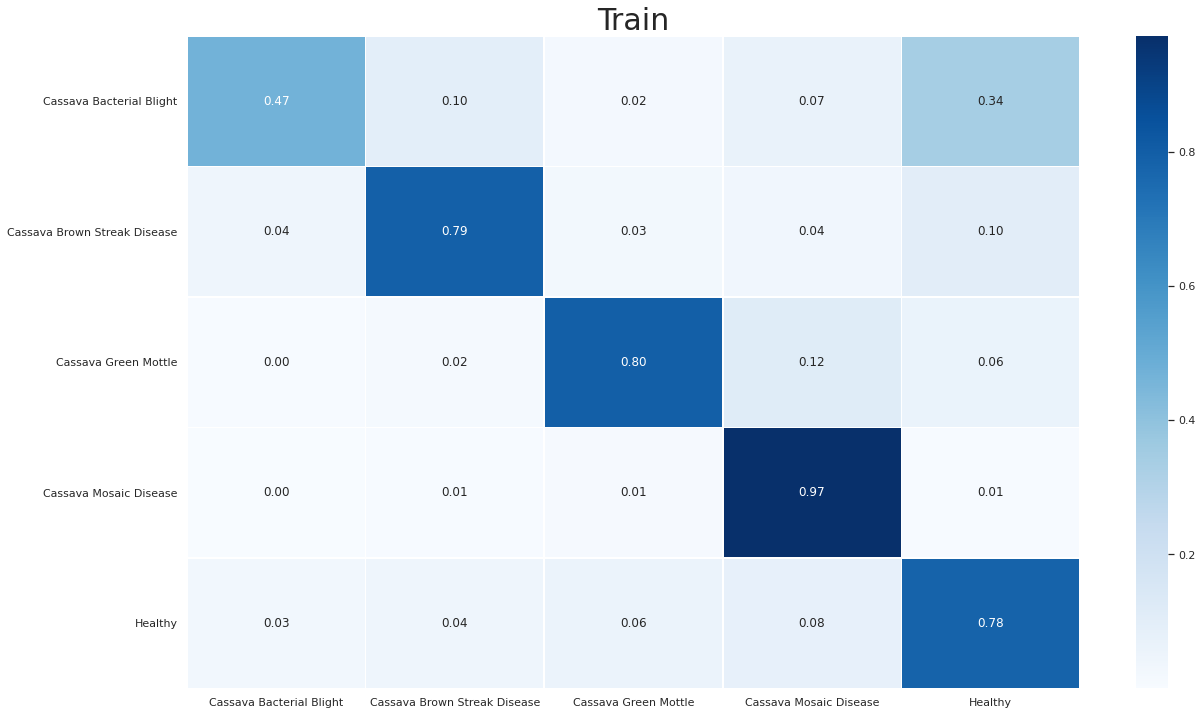

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
cfn_matrix = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T
df_cm = pd.DataFrame(cfn_matrix, index=CLASSES, columns=CLASSES)
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='.2f', linewidths=.5).set_title('Train', fontsize=30)
plt.show()

# Visualize embeddings outputs

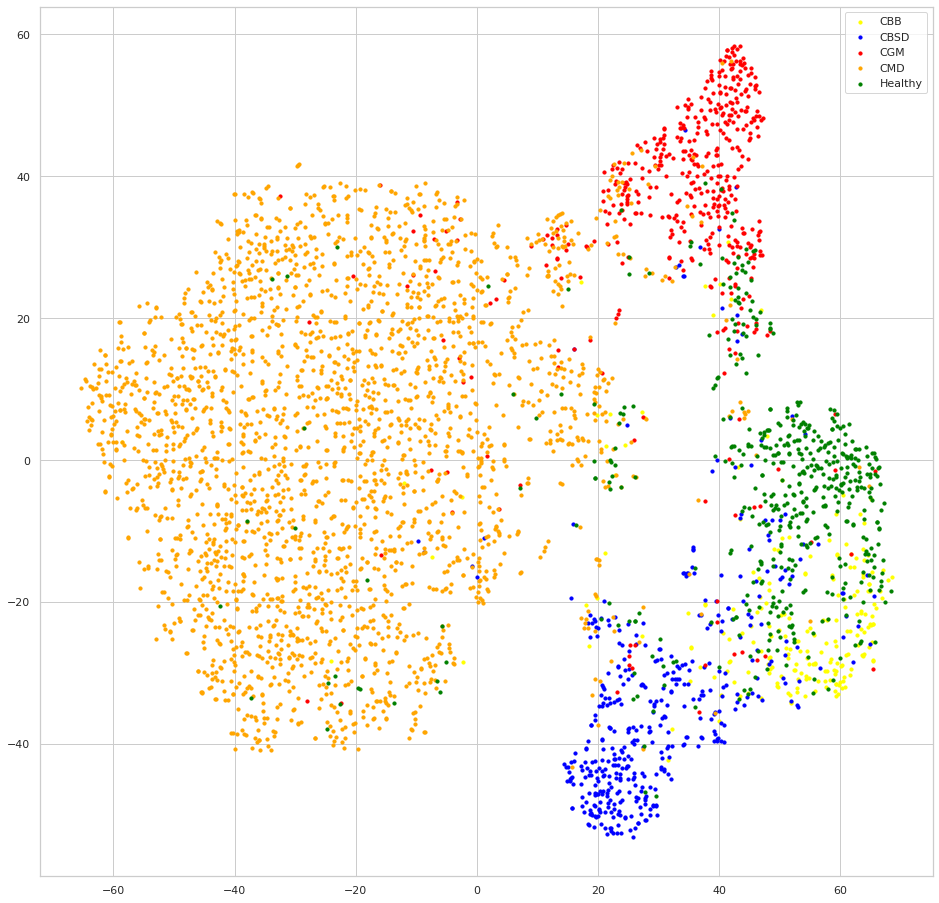

In [18]:
y_embeddings = np.concatenate(oof_embed)

visualize_embeddings(y_embeddings, y_true)

# Visualize predictions

In [19]:
# train_dataset = get_dataset(TRAINING_FILENAMES, ordered=True)
# x_samp, y_samp = dataset_to_numpy_util(train_dataset, 18)
# y_samp = np.argmax(y_samp, axis=-1)

# x_samp_1, y_samp_1 = x_samp[:9,:,:,:], y_samp[:9]
# samp_preds_1 = model.predict(x_samp_1, batch_size=9)
# display_9_images_with_predictions(x_samp_1, samp_preds_1, y_samp_1)

# x_samp_2, y_samp_2 = x_samp[9:,:,:,:], y_samp[9:]
# samp_preds_2 = model.predict(x_samp_2, batch_size=9)
# display_9_images_with_predictions(x_samp_2, samp_preds_2, y_samp_2)